In [ ]:
!pip install kaggle
!pip install torch torchvision
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# SETUP DEPENDENCIES AND KAGGLE API
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Kaggle API credentails
os.environ['KAGGLE_USERNAME'] = 'fredliu876'
os.environ['KAGGLE_KEY'] = '7c8c3537c095b74be5dc7c229e352153'

In [ ]:
!kaggle competitions download -c cs-480-2024-spring
!echo "n" | unzip -q cs-480-2024-spring.zip

 92% 263M/287M [00:01<00:00, 231MB/s]
100% 287M/287M [00:01<00:00, 246MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("data/train.csv")
train_df, val_df = train_test_split(df, test_size=None, random_state=5)


In [ ]:
class PlantDataset(Dataset):
    def __init__(self, dataframe, train, transform, input_scaler, output_scaler):
        self.dataframe = dataframe
        self.train = train
        self.transform = transform
        self.input_scaler = input_scaler
        self.output_scaler = output_scaler

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_id = int(row['id'])
        if self.train:
            image = Image.open(f'data/train_images/{img_id}.jpeg')
        else:
            image = Image.open(f'data/test_images/{img_id}.jpeg')
        if self.transform:
            image = self.transform(image)

        row = row.drop('id')
        input_traits = row.iloc[:163].values.astype('float32')  # First 163 columns are input traits
        input_traits = self.input_scaler.transform(input_traits.reshape(1, -1)).astype('float32')[0]

        output_traits = []
        if self.train:
          output_traits = row.iloc[163:].values.astype('float32') # Last 6 columns are output traits
          output_traits = self.output_scaler.transform(output_traits.reshape(1, -1)).astype('float32')[0]

        input_traits = torch.tensor(input_traits)
        output_traits = torch.tensor(output_traits)

        return img_id, image, input_traits, output_traits

In [ ]:
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

# Fit the input AND output scalers on the training data, this assumes test data has same distribution as training data, which should roughly hold
input_scaler.fit(train_df.iloc[:, 1:164].values)
output_scaler.fit(train_df.iloc[:, 164:].values)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = PlantDataset(train_df, True, transform, input_scaler, output_scaler)
val_dataset = PlantDataset(val_df, True, transform, input_scaler, output_scaler)

train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=False, num_workers=2)

In [ ]:
class PlantCNN(nn.Module):
    def __init__(self):
        super(PlantCNN, self).__init__()
        self.resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

        num_features = self.resnet_model.fc.in_features
        self.resnet_model.fc = nn.Identity()

        self.fc1 = nn.Linear(num_features + 163, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 6)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, image, input_traits):
        image_features = self.resnet_model(image)
        combined_features = torch.cat((image_features, input_traits), dim=1)
        x = nn.ReLU()(self.fc1(combined_features))
        x = self.dropout(x)
        x = nn.ReLU()(self.fc2(x))
        x = self.dropout(x)
        output = self.fc3(x)
        return output

In [ ]:
model = PlantCNN()
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 82.8MB/s]


In [ ]:
# Start training
num_epochs = 3
epochs = list(range(num_epochs))
epoch_losses = []
for epoch in epochs:
    print(f'-------------------------- Epoch {epoch} ----------------------- \n')

    for phase in ['train', 'val']:
        training = phase == "train"
        if training:
            model.train()
        else:
            model.eval()

        running_loss = 0.0

        i = 0
        loader = train_loader if training else val_loader
        for _, images, input_traits, output_traits in loader:
            images = images.to(device)
            input_traits = input_traits.to(device)
            output_traits = output_traits.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(training):
                outputs = model(images, input_traits)
                loss = criterion(outputs, output_traits)

                if training:
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * images.size(0)
            i += 1
            if i % 30 == 0:
              print(f"Finished {'training' if training else 'evaluating'} {i} batches")

        if not training:
          epoch_loss = running_loss / len(val_loader.dataset)
          epoch_losses.append(epoch_loss)

-------------------------- Epoch 0 ----------------------- 

Finished training 30 batches
Finished training 60 batches
Finished training 90 batches
Finished training 120 batches
Finished training 150 batches
Finished training 180 batches
Finished training 210 batches
Finished training 240 batches
Finished training 270 batches
Finished training 300 batches
Finished training 330 batches
Finished training 360 batches
Finished training 390 batches
Finished training 420 batches
Finished training 450 batches
Finished training 480 batches
Finished training 510 batches
Finished training 540 batches
Finished training 570 batches
Finished training 600 batches
Finished training 630 batches
Finished training 660 batches
Finished training 690 batches
Finished training 720 batches
Finished training 750 batches
Finished training 780 batches
Finished training 810 batches
Finished training 840 batches
Finished training 870 batches
Finished training 900 batches
Finished training 930 batches
Finished tra

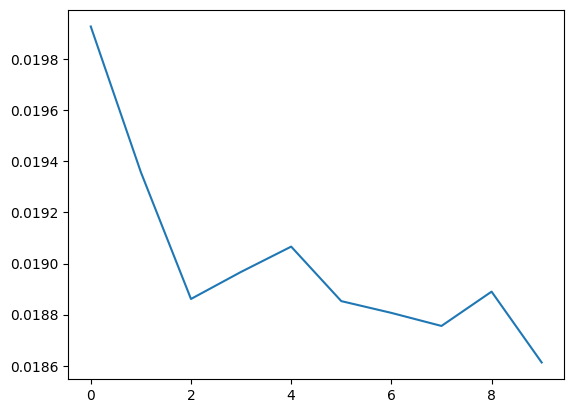

In [ ]:
plt.plot(epochs, epoch_losses)
plt.show()

In [ ]:
test_df = pd.read_csv('data/test.csv')
test_dataset = PlantDataset(test_df, False, transform=transform, input_scaler=input_scaler, output_scaler=output_scaler)
test_loader = DataLoader(test_dataset, batch_size=48, shuffle=False, num_workers=6)

results = []

with torch.no_grad():
    for img_ids, images, input_traits, _ in test_loader:
        images = images.to(device)
        input_traits = input_traits.to(device)
        outputs = model(images, input_traits).cpu().numpy()
        outputs = output_scaler.inverse_transform(outputs)

        for img_id, output in zip(img_ids, outputs):
            results.append([img_id.item()] + output.tolist())

results_df = pd.DataFrame(results, columns=['id', 'X4', 'X11', 'X18', 'X26', 'X50', 'X3112'])
results_df.to_csv('submission.csv', index=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
